# 라이브러리 호출

In [1]:
import os, tqdm, math, random, argparse

import numpy as np
import pandas as pd

from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp
from pytorch_msssim import MS_SSIM
from collections import Counter



In [2]:
print(torch.__version__)

1.7.1


In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

# 장치설정

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [5]:
!nvidia-smi

Mon Mar 21 17:38:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 31%   49C    P5    16W / 160W |   1429MiB /  6144MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# csv파일 열기

In [6]:
train_csv = pd.read_csv('C:/Users/User/Desktop/train.csv')
test_csv = pd.read_csv('C:/Users/User/Desktop/test.csv')

In [7]:
train_csv.head()

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [8]:
test_csv.head()

,img_id,input_img,submission_name
0,20000,test_input_20000.png,test_20000.png
1,20001,test_input_20001.png,test_20001.png
2,20002,test_input_20002.png,test_20002.png
3,20003,test_input_20003.png,test_20003.png
4,20004,test_input_20004.png,test_20004.png


# 이미지 파일 열기

In [9]:
train_all_input_files = 'C:/Users/User/Desktop/train_input_img/'+train_csv['input_img']
train_all_label_files = 'C:/Users/User/Desktop/train_label_img/'+train_csv['label_img']
test_all_input_files = 'C:/Users/User/Desktop/test_input_img/'+test_csv['input_img']

In [10]:
len(train_all_input_files), len(train_all_label_files) , len(test_all_input_files)

(622, 622, 20)

In [11]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

In [12]:
len(train_input_files), len(train_label_files) , len(test_all_input_files)

(562, 562, 20)

In [13]:
vaild_input_files = train_all_input_files[:60].to_numpy()
vaild_label_files = train_all_label_files[:60].to_numpy()

In [14]:
len(vaild_input_files), len(vaild_label_files)

(60, 60)

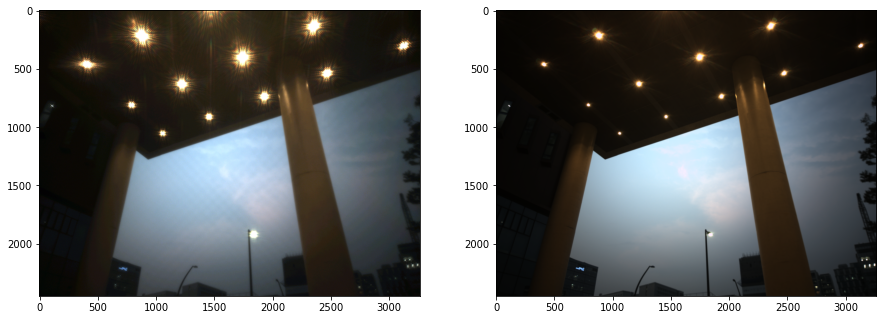

C:/Users/User/Desktop/train_input_img/train_input_10060.png C:/Users/User/Desktop/train_label_img/train_label_10060.png 



In [15]:
import cv2

for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break

# customdataset 설정

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, label,w,h ,is_train=True):
        self.data  = data
        self.label = label
        self.w = w
        self.h = h
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image, label):
        
        resizer = transforms.Resize(size=(self.h, self.w))
        image = resizer(image)
        label = resizer(label)
    
  

        image = TF.to_tensor(image)
        label = TF.to_tensor(label)
        return image, label
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        label_img  = Image.open(self.label[idx])
        
        origin_img, label_img = self.transform(origin_img, label_img)
        return origin_img, label_img

In [17]:
class testDataset(Dataset):
    def __init__(self, data,is_train=True):
        self.data  = data
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((384, 512))
        ])
        image = transform(image)
        
        return image
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        
        origin_img = self.transform(origin_img)
        return origin_img

In [18]:
train_dataset = CustomDataset(train_input_files, train_label_files,512,384)
vaild_dataset = CustomDataset(vaild_input_files, vaild_label_files,512,384)
test_dataset = testDataset(test_all_input_files)

In [19]:
print(len(train_dataset))

562


In [20]:
print(len(vaild_dataset))

60


In [21]:
print(len(test_dataset))

20


In [22]:
train_dataset[0][0].shape

torch.Size([3, 384, 512])

In [23]:
vaild_dataset[0][0].shape

torch.Size([3, 384, 512])

In [24]:
test_dataset[0].shape

torch.Size([3, 384, 512])

In [25]:
train_loader = DataLoader(train_dataset , batch_size = 4, shuffle = False)
vaild_loader = DataLoader(vaild_dataset , batch_size = 4, shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = 1 , shuffle = False )

In [26]:
print(len(train_loader))

141


In [27]:
print(len(vaild_loader))

15


In [28]:
print(len(test_loader))

20


# model

In [29]:
'''
model = smp.UnetPlusPlus(encoder_name='resnet18',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
                '''

"\nmodel = smp.UnetPlusPlus(encoder_name='resnet18',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n                "

In [30]:
'''
model = smp.UnetPlusPlus(encoder_name='efficientnet-b4',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
                '''
                

"\nmodel = smp.UnetPlusPlus(encoder_name='efficientnet-b4',\n                encoder_weights='imagenet',\n                in_channels=3, classes=3, activation='sigmoid')\n                "

In [31]:

model = smp.UnetPlusPlus(encoder_name='resnet18',
                encoder_weights='imagenet',
                in_channels=3, classes=3, activation='sigmoid')
              

In [32]:
model.to(device)
model


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# train

In [33]:
criterion = torch.nn.L1Loss().to(device)
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 10, gamma=0.8)

In [34]:
train_loss = []
vaild_loss=[]
for epoch in range(300):
    total_loss = 0
    model.train()
    
    for image , label in tqdm(train_loader,total=len(train_loader),leave = False):
        image = image.to(device)
        label = label.to(device)
        output = model(image.float())
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))
    print("epoch :" , epoch+1 , "loss :" , total_loss/len(train_loader))
    
    scheduler.step()
    
    idx = 1
    
    model.eval()
    with torch.no_grad():
        for image , label in tqdm(vaild_loader,total=len(vaild_loader),leave = False):
            image = image.to(device)
            label = label.to(device)
            output = model(image.float())
            loss = torch.sqrt(loss_fn(output,label))
            
            total_loss += loss.item()
            

            target_path = 'E:/custom_unet/' + str(epoch+1)+'/'
            if not os.path.exists(target_path):
                os.makedirs(target_path, exist_ok=True)

            grid = torchvision.utils.make_grid(tensor=torch.vstack([image,label,output]), nrow=image.shape[0])    # Saving results
            torchvision.utils.save_image(grid, target_path+str(idx)+'.png')
            idx +=1
        vaild_loss.append(total_loss/len(vaild_loader))
        print("val_epoch :" , epoch+1 , "val_loss :" , total_loss/len(vaild_loader))
    
        
    

  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 1 loss : 0.12508269967445246


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 1 val_loss : 1.313118223597606


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 2 loss : 0.0815233715301287


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 2 val_loss : 0.8641527434190114


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 3 loss : 0.07094774944773803


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 3 val_loss : 0.7581968272725741


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 4 loss : 0.06627485064908545


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 4 val_loss : 0.7149071843673785


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 5 loss : 0.06341317565517222


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 5 val_loss : 0.685753675053517


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 6 loss : 0.05540444877606335


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 6 val_loss : 0.6103329297155142


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 7 loss : 0.05610262224754543


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 7 val_loss : 0.6178215203185876


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 8 loss : 0.0545193188368006


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 8 val_loss : 0.604559435447057


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 9 loss : 0.05043744886333638


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 9 val_loss : 0.5621713445832331


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 10 loss : 0.04894620291096099


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 10 val_loss : 0.5446624773244063


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 11 loss : 0.04621521893439563


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 11 val_loss : 0.519590908040603


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 12 loss : 0.04453572606443302


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 12 val_loss : 0.49904658117642003


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 13 loss : 0.04356868606694835


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 13 val_loss : 0.48886733148247


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 14 loss : 0.0427844893742115


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 14 val_loss : 0.47755863691369693


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 15 loss : 0.04238566367867145


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 15 val_loss : 0.4776524151364962


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 16 loss : 0.04137335024800495


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 16 val_loss : 0.46642207199086744


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 17 loss : 0.04128639710446199


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 17 val_loss : 0.46553789687653385


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 18 loss : 0.04098824107134384


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 18 val_loss : 0.45964136042942605


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 19 loss : 0.040313134802148695


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 19 val_loss : 0.4569952167570591


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 20 loss : 0.03899638039053332


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 20 val_loss : 0.4407797506699959


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 21 loss : 0.039207704352043196


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 21 val_loss : 0.44569806195795536


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 22 loss : 0.03933039373645546


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 22 val_loss : 0.444187543541193


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 23 loss : 0.03842464055046967


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 23 val_loss : 0.44101403206586837


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 24 loss : 0.037511722997147987


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 24 val_loss : 0.43650929952661194


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 25 loss : 0.037873897767553094


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 25 val_loss : 0.42995615489780903


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 26 loss : 0.03659196331410121


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 26 val_loss : 0.4201812238742908


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 27 loss : 0.03570265879075155


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 27 val_loss : 0.41233939739565056


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 28 loss : 0.034613251659675694


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 28 val_loss : 0.4185087612519662


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 29 loss : 0.03450986225792068


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 29 val_loss : 0.3970185898865263


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 30 loss : 0.036069260830891896


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 30 val_loss : 0.4135920058935881


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 31 loss : 0.035085851788943544


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 31 val_loss : 0.4069914328555266


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 32 loss : 0.035145657321979815


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 32 val_loss : 0.404835132881999


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 33 loss : 0.03363052858634198


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 33 val_loss : 0.3889476170142492


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 34 loss : 0.03304165023121428


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 34 val_loss : 0.3882884934544563


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 35 loss : 0.032134369953621365


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 35 val_loss : 0.37941738876203696


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 36 loss : 0.03180303044141607


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 36 val_loss : 0.3764036908745766


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 37 loss : 0.031157562522389364


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 37 val_loss : 0.3712069402138392


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 38 loss : 0.032236123787807235


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 38 val_loss : 0.3734678899248441


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 39 loss : 0.031862753377368686


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 39 val_loss : 0.37103629962851603


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 40 loss : 0.031214863081720282


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 40 val_loss : 0.367297585743169


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 41 loss : 0.03096700574647873


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 41 val_loss : 0.3627796946714322


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 42 loss : 0.02998543547875915


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 42 val_loss : 0.3610095735639334


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 43 loss : 0.030901840868148397


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 43 val_loss : 0.3625078191359838


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 44 loss : 0.03097820198097339


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 44 val_loss : 0.38155656463156146


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 45 loss : 0.029930253315003628


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 45 val_loss : 0.36679263977954785


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 46 loss : 0.029108422656431265


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 46 val_loss : 0.34852809632817905


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 47 loss : 0.028476306118388126


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 47 val_loss : 0.35177889186888933


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 48 loss : 0.02755315875938387


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 48 val_loss : 0.34283854061116775


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 49 loss : 0.027691862367569132


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 49 val_loss : 0.3420765571296215


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 50 loss : 0.027935227286731097


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 50 val_loss : 0.34286971638600033


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 51 loss : 0.028704602396815805


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 51 val_loss : 0.3571974130347371


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 52 loss : 0.02806874982193641


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 52 val_loss : 0.336908406453828


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 53 loss : 0.027772728750046265


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 53 val_loss : 0.3318987049162388


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 54 loss : 0.029102026544352795


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 54 val_loss : 0.34707841761410235


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 55 loss : 0.027029729487889623


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 55 val_loss : 0.3256165803099672


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 56 loss : 0.027784689620190057


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 56 val_loss : 0.3373714068904519


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 57 loss : 0.02715911127045645


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 57 val_loss : 0.33145706554253895


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 58 loss : 0.025763607900986012


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 58 val_loss : 0.3166289433216055


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 59 loss : 0.02487090835678028


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 59 val_loss : 0.306677668603758


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 60 loss : 0.024624598463534885


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 60 val_loss : 0.30644756375501553


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 61 loss : 0.02654429572693845


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 61 val_loss : 0.31731385737657547


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 62 loss : 0.024995695073025445


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 62 val_loss : 0.30253061341742676


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 63 loss : 0.02429846382917876


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 63 val_loss : 0.2984513376529018


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 64 loss : 0.023608430506701163


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 64 val_loss : 0.301041121284167


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 65 loss : 0.023193998321732308


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 65 val_loss : 0.29475972497214875


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 66 loss : 0.023227567289103853


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 66 val_loss : 0.29402423625191054


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 67 loss : 0.02318670189813942


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 67 val_loss : 0.28830555342137815


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 68 loss : 0.02324528366670752


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 68 val_loss : 0.2888480425501863


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 69 loss : 0.023612304108468353


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 69 val_loss : 0.3022475015372038


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 70 loss : 0.023017846477211366


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 70 val_loss : 0.2956361853207151


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 71 loss : 0.022647125091641507


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 71 val_loss : 0.28890091441571714


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 72 loss : 0.021943072167535622


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 72 val_loss : 0.2809677795196573


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 73 loss : 0.021529679695236767


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 73 val_loss : 0.28069889831046263


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 74 loss : 0.021701144404603658


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 74 val_loss : 0.2835756716007988


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 75 loss : 0.022061630911755222


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 75 val_loss : 0.282508709654212


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 76 loss : 0.02187306390982782


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 76 val_loss : 0.27178807898114127


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 77 loss : 0.021378199404752846


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 77 val_loss : 0.27104352923731007


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 78 loss : 0.021310356425795148


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 78 val_loss : 0.27444461099803447


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 79 loss : 0.021179285237288223


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 79 val_loss : 0.27911980021744964


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 80 loss : 0.021021867190745284


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 80 val_loss : 0.27358851563185455


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 81 loss : 0.0213495906878342


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 81 val_loss : 0.2733856910839677


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 82 loss : 0.02047560324377202


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 82 val_loss : 0.26579899738232293


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 83 loss : 0.01953440090205441


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 83 val_loss : 0.2573900602137049


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 84 loss : 0.019417638223327642


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 84 val_loss : 0.2542421491195758


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 85 loss : 0.019384222151381327


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 85 val_loss : 0.25547954222808283


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 86 loss : 0.019385616559244638


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 86 val_loss : 0.2537566994006435


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 87 loss : 0.019713177761815963


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 87 val_loss : 0.2568269388129314


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 88 loss : 0.0201984639048365


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 88 val_loss : 0.2600214147319396


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 89 loss : 0.020503861459751502


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 89 val_loss : 0.26097758697966733


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 90 loss : 0.021058436390673015


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 90 val_loss : 0.27579477814336617


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 91 loss : 0.02042380372947412


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 91 val_loss : 0.2691641006618738


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 92 loss : 0.019518133662376844


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 92 val_loss : 0.25385811490317184


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 93 loss : 0.019374749108039317


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 93 val_loss : 0.2551370730623603


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 94 loss : 0.01906621802915284


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 94 val_loss : 0.25644467305392027


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 95 loss : 0.01923972847111893


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 95 val_loss : 0.25174273531883956


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 96 loss : 0.019631499688781744


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 96 val_loss : 0.2513489625106255


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 97 loss : 0.0187759635415166


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 97 val_loss : 0.24348911549896002


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 98 loss : 0.0184452859156415


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 98 val_loss : 0.24440635635207097


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 99 loss : 0.018536573797728575


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 99 val_loss : 0.2503928324207664


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 100 loss : 0.018298389469372466


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 100 val_loss : 0.24880728212495645


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 101 loss : 0.018567357892632908


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 101 val_loss : 0.24832822649429243


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 102 loss : 0.018413359246461106


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 102 val_loss : 0.24030020522574583


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 103 loss : 0.01827013386241722


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 103 val_loss : 0.2371632036442558


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 104 loss : 0.01833977323712398


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 104 val_loss : 0.24068790779759486


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 105 loss : 0.018251112404655902


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 105 val_loss : 0.24022945786515873


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 106 loss : 0.017998954730359375


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 106 val_loss : 0.2380027774721384


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 107 loss : 0.017984829149506193


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 107 val_loss : 0.23983093493928512


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 108 loss : 0.017754149748712568


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 108 val_loss : 0.2420260744790236


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 109 loss : 0.017547138174005012


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 109 val_loss : 0.23739472758024932


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 110 loss : 0.017442236608224557


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 110 val_loss : 0.23306074316302935


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 111 loss : 0.017626636701219892


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 111 val_loss : 0.23771110021819672


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 112 loss : 0.01764612749932294


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 112 val_loss : 0.23624419340242941


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 113 loss : 0.017607773046491415


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 113 val_loss : 0.23709516717741888


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 114 loss : 0.017301971317394405


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 114 val_loss : 0.23694099014004072


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 115 loss : 0.017180181187676623


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 115 val_loss : 0.2376894443606337


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 116 loss : 0.017070588668980074


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 116 val_loss : 0.23320495852579673


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 117 loss : 0.01693321166044854


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 117 val_loss : 0.22996185533702374


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 118 loss : 0.01698797856001778


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 118 val_loss : 0.2290900582447648


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 119 loss : 0.016923979638104745


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 119 val_loss : 0.228052044659853


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 120 loss : 0.016993566072737495


  0%|          | 0/15 [00:01<?, ?it/s]

val_epoch : 120 val_loss : 0.2302760255212585


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 121 loss : 0.01714480227744537


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 121 val_loss : 0.23318441739926735


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 122 loss : 0.016928927754943677


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 122 val_loss : 0.22589524667710065


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 123 loss : 0.01683130650946223


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 123 val_loss : 0.22338907414426407


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 124 loss : 0.016878704480985378


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 124 val_loss : 0.22635620199143885


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 125 loss : 0.017019537957847542


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 125 val_loss : 0.22914012769858041


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 126 loss : 0.01685421275807188


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 126 val_loss : 0.23006914344926674


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 127 loss : 0.016810570823702405


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 127 val_loss : 0.22789351182679335


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 128 loss : 0.017227068662326386


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 128 val_loss : 0.23107358229657013


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 129 loss : 0.017079974049107827


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 129 val_loss : 0.23370830286294222


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 130 loss : 0.016900896134370184


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 130 val_loss : 0.23736196911583343


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 131 loss : 0.016835140520112313


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 131 val_loss : 0.2323252784088254


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 132 loss : 0.01639681604710665


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 132 val_loss : 0.22392848326514164


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 133 loss : 0.016241584957332897


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 133 val_loss : 0.2232872295503815


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 134 loss : 0.016079237882761246


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 134 val_loss : 0.2227944461007913


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 135 loss : 0.01615521926697053


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 135 val_loss : 0.22456230365981658


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 136 loss : 0.016075669279229557


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 136 val_loss : 0.22144285328686236


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 137 loss : 0.015995192044275873


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 137 val_loss : 0.21879460451503593


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 138 loss : 0.0159617511106404


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 138 val_loss : 0.21889247577637433


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 139 loss : 0.015954726012357583


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 139 val_loss : 0.22093570816020172


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 140 loss : 0.016046855268431894


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 140 val_loss : 0.22383783298234144


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 141 loss : 0.0161259383729375


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 141 val_loss : 0.2253117756297191


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 142 loss : 0.016329951320134158


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 142 val_loss : 0.22755136514703433


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 143 loss : 0.0160167488064749


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 143 val_loss : 0.2266934355099996


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 144 loss : 0.01587308997433659


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 144 val_loss : 0.2259133171290159


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 145 loss : 0.01580540018803473


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 145 val_loss : 0.22285103891044855


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 146 loss : 0.015802280013020156


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 146 val_loss : 0.22102012435595195


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 147 loss : 0.015705921350324406


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 147 val_loss : 0.21976949560145537


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 148 loss : 0.015667227413901624


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 148 val_loss : 0.2203520057722926


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 149 loss : 0.01576251957354182


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 149 val_loss : 0.22043845237543186


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 150 loss : 0.01572673516810363


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 150 val_loss : 0.21856481457750002


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 151 loss : 0.015890037660744597


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 151 val_loss : 0.21897498772790033


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 152 loss : 0.01572084926227306


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 152 val_loss : 0.22145864789684613


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 153 loss : 0.01570802528728196


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 153 val_loss : 0.22178476409365733


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 154 loss : 0.015585813109914885


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 154 val_loss : 0.22024047914892436


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 155 loss : 0.015496317039620369


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 155 val_loss : 0.21993204833318789


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 156 loss : 0.015421848512974614


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 156 val_loss : 0.21995239984244108


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 157 loss : 0.015396651871343876


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 157 val_loss : 0.21894129328429698


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 158 loss : 0.015370207257463154


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 158 val_loss : 0.21703640489528578


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 159 loss : 0.015344173158684098


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 159 val_loss : 0.21556501084317764


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 160 loss : 0.015327997690608315


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 160 val_loss : 0.21539723103245098


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 161 loss : 0.015387873885268015


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 161 val_loss : 0.21556586623191834


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 162 loss : 0.015368113300848937


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 162 val_loss : 0.21654438941429058


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 163 loss : 0.015299100012696803


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 163 val_loss : 0.21657328438013793


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 164 loss : 0.01526625090483444


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 164 val_loss : 0.21794970563302438


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 165 loss : 0.01526509175830065


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 165 val_loss : 0.21866383186231056


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 166 loss : 0.015244227021615556


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 166 val_loss : 0.2177396231641372


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 167 loss : 0.015213431846614637


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 167 val_loss : 0.21688491171225904


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 168 loss : 0.015205976051271808


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 168 val_loss : 0.21699129324406385


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 169 loss : 0.01522808697352067


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 169 val_loss : 0.21609217608347536


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 170 loss : 0.015209716037972599


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 170 val_loss : 0.21407966303328674


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 171 loss : 0.015207424495659821


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 171 val_loss : 0.21376200169324874


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 172 loss : 0.015161803315875801


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 172 val_loss : 0.21542967973897856


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 173 loss : 0.015115341977447483


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 173 val_loss : 0.21594557017087937


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 174 loss : 0.015101421327191465


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 174 val_loss : 0.21640231081595024


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 175 loss : 0.015054761580726567


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 175 val_loss : 0.21572737578923504


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 176 loss : 0.015009261628097676


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 176 val_loss : 0.21480113628009956


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 177 loss : 0.014972969483425642


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 177 val_loss : 0.213407800005128


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 178 loss : 0.014943961281963486


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 178 val_loss : 0.21254986341421803


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 179 loss : 0.014924415519315722


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 179 val_loss : 0.2119965648278594


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 180 loss : 0.01490933990026725


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 180 val_loss : 0.2120942602865398


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 181 loss : 0.014914433887981355


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 181 val_loss : 0.21246324094633262


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 182 loss : 0.014891154789993314


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 182 val_loss : 0.2133129680218796


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 183 loss : 0.014875659124648317


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 183 val_loss : 0.21367371429999668


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 184 loss : 0.01487657570458473


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 184 val_loss : 0.21368030086159706


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 185 loss : 0.014863033359540059


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 185 val_loss : 0.2130677000619471


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 186 loss : 0.014843920285397388


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 186 val_loss : 0.21231093232830364


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 187 loss : 0.014833881245622186


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 187 val_loss : 0.2112875035343071


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 188 loss : 0.014820292463248714


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 188 val_loss : 0.21099321050569414


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 189 loss : 0.014793204424361177


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 189 val_loss : 0.21085746564591926


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 190 loss : 0.014772369625403526


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 190 val_loss : 0.2113122238467137


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 191 loss : 0.014758165268531295


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 191 val_loss : 0.2119689666045209


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 192 loss : 0.014722763395584221


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 192 val_loss : 0.21182040659089882


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 193 loss : 0.014702984052611159


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 193 val_loss : 0.21148521608362594


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 194 loss : 0.014686100564712116


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 194 val_loss : 0.21089762458577752


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 195 loss : 0.014674276902822527


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 195 val_loss : 0.21034366510187585


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 196 loss : 0.014669889442173513


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 196 val_loss : 0.20989788699274262


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 197 loss : 0.014670845167381121


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 197 val_loss : 0.2096089893952012


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 198 loss : 0.014666387177211172


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 198 val_loss : 0.20994064199427764


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 199 loss : 0.014661178702871638


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 199 val_loss : 0.2104450041738649


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 200 loss : 0.014648331157493253


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 200 val_loss : 0.21067340051134428


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 201 loss : 0.014634614080481284


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 201 val_loss : 0.21078723591441909


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 202 loss : 0.014601897547378185


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 202 val_loss : 0.21002765391021966


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 203 loss : 0.01457566844220174


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 203 val_loss : 0.20935559219991168


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 204 loss : 0.014557043988759635


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 204 val_loss : 0.2089406292885542


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 205 loss : 0.01454479609622706


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 205 val_loss : 0.20878320935492714


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 206 loss : 0.014536909481629412


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 206 val_loss : 0.2088711670289437


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 207 loss : 0.014525104049883835


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 207 val_loss : 0.208903156965971


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 208 loss : 0.014515318752576908


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 208 val_loss : 0.20921876166636746


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 209 loss : 0.01450608856645776


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 209 val_loss : 0.20924560983354848


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 210 loss : 0.014496807563812174


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 210 val_loss : 0.20937813917795817


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 211 loss : 0.014486684774359068


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 211 val_loss : 0.20880033088227112


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 212 loss : 0.014475070243925914


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 212 val_loss : 0.2085007266451915


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 213 loss : 0.014462755926957368


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 213 val_loss : 0.20801288212339084


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 214 loss : 0.014456164544276524


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 214 val_loss : 0.20810707438116272


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 215 loss : 0.014446578926492667


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 215 val_loss : 0.20807767764975627


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 216 loss : 0.01443758769727028


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 216 val_loss : 0.20845636467759807


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 217 loss : 0.014432763370374838


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 217 val_loss : 0.2085549170151353


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 218 loss : 0.014426939367772416


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 218 val_loss : 0.2087316934640209


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 219 loss : 0.014425846143685122


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 219 val_loss : 0.2085409648406009


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 220 loss : 0.014422342854928463


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 220 val_loss : 0.20823911813398202


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 221 loss : 0.014409851794732167


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 221 val_loss : 0.20756926496202746


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 222 loss : 0.014391227787135974


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 222 val_loss : 0.20755702179546157


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 223 loss : 0.014376886241824914


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 223 val_loss : 0.20775105580687522


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 224 loss : 0.01436403325052126


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 224 val_loss : 0.20783726945519448


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 225 loss : 0.01435697327718033


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 225 val_loss : 0.20790097868690888


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 226 loss : 0.014347271339848955


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 226 val_loss : 0.20767367475976548


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 227 loss : 0.014340492170171958


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 227 val_loss : 0.20757738531877598


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 228 loss : 0.014333068743242439


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 228 val_loss : 0.20728809311985968


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 229 loss : 0.014326868400453253


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 229 val_loss : 0.20730008700241645


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 230 loss : 0.014319695281327193


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 230 val_loss : 0.20726561682919661


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 231 loss : 0.01431069233461369


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 231 val_loss : 0.20742042670026423


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 232 loss : 0.014302520421564791


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 232 val_loss : 0.2074530537861089


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 233 loss : 0.014296269671766892


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 233 val_loss : 0.20739334827909867


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 234 loss : 0.014290064018457494


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 234 val_loss : 0.20721928030252457


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 235 loss : 0.014284189631964298


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 235 val_loss : 0.2070465122660001


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 236 loss : 0.014278632175864269


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 236 val_loss : 0.20702176333094638


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 237 loss : 0.014273211984162001


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 237 val_loss : 0.20700191200400392


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 238 loss : 0.014267375966837855


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 238 val_loss : 0.20714108419294158


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 239 loss : 0.014261243118514828


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 239 val_loss : 0.20709854196757077


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 240 loss : 0.014256068743131262


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 240 val_loss : 0.20714991446584463


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 241 loss : 0.014246654673644625


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 241 val_loss : 0.206895696464926


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 242 loss : 0.014238003370556848


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 242 val_loss : 0.20680854339152574


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 243 loss : 0.014231853167268825


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 243 val_loss : 0.20674335043877362


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 244 loss : 0.014226173922578071


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 244 val_loss : 0.20677704395105442


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 245 loss : 0.01422079172685531


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 245 val_loss : 0.20676177426551778


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 246 loss : 0.01421566945930005


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 246 val_loss : 0.20676146289333702


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 247 loss : 0.014210321646553616


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 247 val_loss : 0.2066820385865867


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 248 loss : 0.014205365864467537


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 248 val_loss : 0.20665225132058065


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 249 loss : 0.014200286536827578


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 249 val_loss : 0.20658832024782897


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 250 loss : 0.014195366504978626


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 250 val_loss : 0.20658320089181265


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 251 loss : 0.01418823535811711


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 251 val_loss : 0.20651179958755772


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 252 loss : 0.014182753368868685


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 252 val_loss : 0.2064999293225507


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 253 loss : 0.014178079813850898


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 253 val_loss : 0.20645383773371578


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 254 loss : 0.014173657088441418


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 254 val_loss : 0.20640946592514714


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 255 loss : 0.014169059839126067


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 255 val_loss : 0.2063733134418726


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 256 loss : 0.014164651440231935


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 256 val_loss : 0.2063505319878459


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 257 loss : 0.014160200131145563


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 257 val_loss : 0.20631665311132869


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 258 loss : 0.014155639388354112


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 258 val_loss : 0.20629891070226827


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 259 loss : 0.014151207590805934


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 259 val_loss : 0.20626537095134456


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 260 loss : 0.014146841788360624


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 260 val_loss : 0.2062301557821532


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 261 loss : 0.014140748554272643


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 261 val_loss : 0.20615517133846878


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 262 loss : 0.014136133834402612


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 262 val_loss : 0.20611313382784527


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 263 loss : 0.01413224622646862


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 263 val_loss : 0.2061078847385943


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 264 loss : 0.014128346015956807


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 264 val_loss : 0.2060604368026058


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 265 loss : 0.0141246273472958


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 265 val_loss : 0.20605841437354683


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 266 loss : 0.014120908460665679


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 266 val_loss : 0.2060151166593035


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 267 loss : 0.014117087600818763


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 267 val_loss : 0.20599285028874875


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 268 loss : 0.014113218503746581


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 268 val_loss : 0.20596108722190062


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 269 loss : 0.014109488239789263


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 269 val_loss : 0.20594122738887866


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 270 loss : 0.014105719692529516


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 270 val_loss : 0.20591166416803997


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 271 loss : 0.014100781334762244


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 271 val_loss : 0.20586127021039527


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 272 loss : 0.014097143146242445


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 272 val_loss : 0.20583122568204998


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 273 loss : 0.01409391840219709


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 273 val_loss : 0.20581428613513708


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 274 loss : 0.014090725659980631


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 274 val_loss : 0.20579435871914029


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 275 loss : 0.014087626723744345


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 275 val_loss : 0.2057677025596301


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 276 loss : 0.014084487806688598


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 276 val_loss : 0.20575063995396098


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 277 loss : 0.014081404055633866


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 277 val_loss : 0.20572474965204796


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 278 loss : 0.014078216623937618


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 278 val_loss : 0.20570686692371964


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 279 loss : 0.014075086788928255


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 279 val_loss : 0.2056810103356838


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 280 loss : 0.014071965527370677


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 280 val_loss : 0.20566884108508626


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 281 loss : 0.01406775803325024


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 281 val_loss : 0.2056178589661916


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 282 loss : 0.014064916300567542


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 282 val_loss : 0.2056069401713709


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 283 loss : 0.01406233534811342


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 283 val_loss : 0.20558918258175254


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 284 loss : 0.014059726162054014


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 284 val_loss : 0.205569285278519


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 285 loss : 0.014057177544987582


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 285 val_loss : 0.20554979564622045


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 286 loss : 0.014054632048842544


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 286 val_loss : 0.20553757483139634


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 287 loss : 0.014052099908259532


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 287 val_loss : 0.20551735668753585


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 288 loss : 0.014049489067616404


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 288 val_loss : 0.20550273150826495


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 289 loss : 0.014046927656423538


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 289 val_loss : 0.2054873676970601


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 290 loss : 0.014044387540152522


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 290 val_loss : 0.20547404161964852


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 291 loss : 0.014040934238979157


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 291 val_loss : 0.20543674839039644


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 292 loss : 0.014038695940576124


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 292 val_loss : 0.20542069381723801


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 293 loss : 0.014036599682075969


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 293 val_loss : 0.2054105150513351


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 294 loss : 0.014034525326169129


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 294 val_loss : 0.20539355079332988


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 295 loss : 0.014032457836289355


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 295 val_loss : 0.20538259266565242


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 296 loss : 0.014030392010900991


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 296 val_loss : 0.2053684903929631


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 297 loss : 0.014028333652606036


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 297 val_loss : 0.20535530966396134


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 298 loss : 0.01402627187946164


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 298 val_loss : 0.20534538775682448


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 299 loss : 0.014024233336540614


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 299 val_loss : 0.20533291061098377


  0%|          | 0/141 [00:00<?, ?it/s]

epoch : 300 loss : 0.014022121030890138


  0%|          | 0/15 [00:00<?, ?it/s]

val_epoch : 300 val_loss : 0.20532027405376235


# vaild_시각화

In [62]:
results = [y for x in os.walk('E:/custom_unet/300') for y in glob(os.path.join(x[0], '*.png'))]

In [63]:
width = 384
height = 512

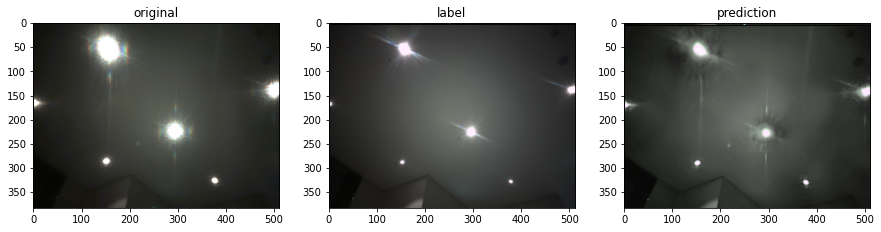

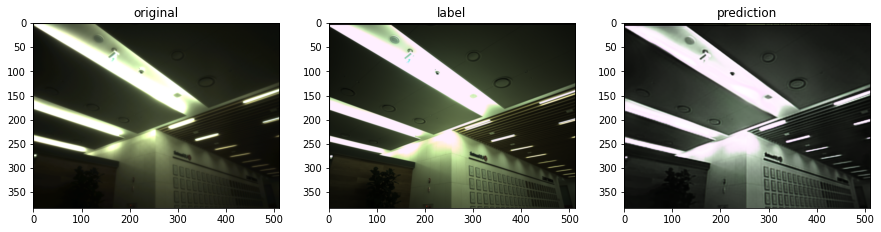

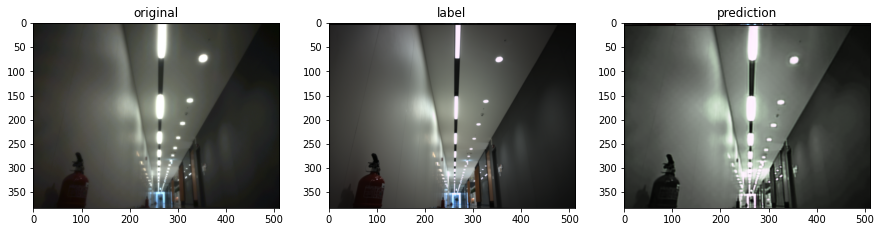

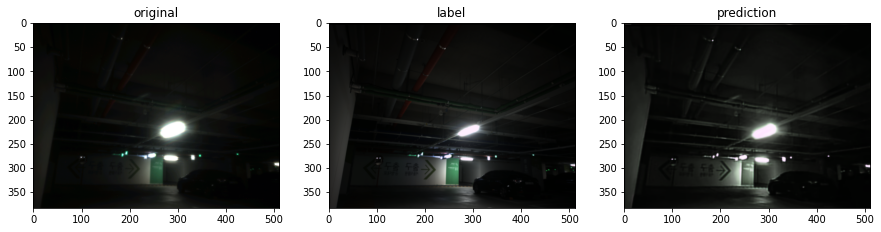

In [64]:
for idx, each_result in enumerate(results):
    if idx % 4 ==0:
        input  = np.array(Image.open(each_result))[:width, :height, :]
        target = np.array(Image.open(each_result))[width*1:width*2, :height, :]
        recon  = np.array(Image.open(each_result))[width*2:width*3, :height, :]
        
 
        _, ax = plt.subplots(1, 3, figsize=(15,15))

        ax[0].set_title('original')
        ax[0].imshow(input)

        ax[1].set_title('label')
        ax[1].imshow(target)

        ax[2].set_title('prediction')
        ax[2].imshow(recon)

        plt.show()

# test image 예측

In [38]:
model.eval()
with torch.no_grad():
    for image  in test_loader:
        image = image
        output = model(image.to(device))    
        
        break

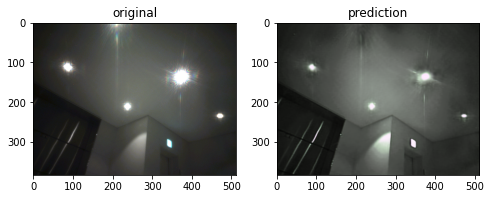

In [39]:
for i in range(1):
    
    fix , ax = plt.subplots(ncols = 2,figsize = (8,8))
    ax[0].set_title('original')
    ax[0].imshow(np.moveaxis(image[i].cpu().numpy(),0,2))
    out = output.detach().cpu()[i]
    ax[1].set_title('prediction')
    ax[1].imshow(np.moveaxis(out.cpu().numpy(),0,2))

In [40]:
torch.save(model.state_dict(), 'E:/model_save/'+'mobilenet.pt')
#model.load_state_dict(torch.load(PATH))

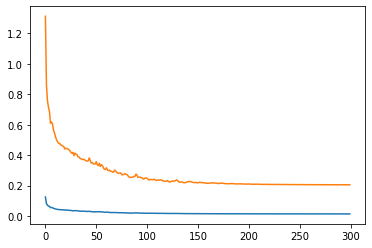

In [41]:
plt.plot(train_loss)
plt.plot(vaild_loss)

In [42]:
def test(model, test_load, model_name):
    model.eval()
    
    with torch.no_grad():
        for num, data in tqdm(enumerate(test_load), total=len(test_load)):
            data = data.to(device)
            
            output = model(data)
            
            out = transforms.transforms.Resize((348, 512))(output)

            torchvision.utils.save_image(out, f'C:/Users/User/Desktop/{model_name}/test_{20000+num}.png')

In [43]:
test(model, test_loader, 'mobilenet')

  0%|          | 0/20 [00:00<?, ?it/s]